In [1]:
import json
from pathlib import Path
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

In [2]:
#q = Path('annotations/person_keypoints_train2014.json').open()
#annotations_data = json.load(q)
#82,783  images
#185,316 annotations
#{2: 7663,
# 1: 17293,
# 6: 1450,
# 8: 1027,
# 10: 869,
# 5: 1959,
# 11: 865,
# 3: 4192,
# 7: 1193,
# 13: 956,
# 14: 3268,
# 4: 2757,
# 12: 815,
# 9: 858,
# 15: 6,
# 16: 1,
# 18: 1,
# 20: 1}

In [94]:
'''
for ann in annotations_data['annotations']:
    if 'segmentation' in ann:
        del ann['segmentation']
    if 'area' in ann:
        del ann['area']
    if 'bbox' in ann:
        del ann['bbox']
    if 'category_id' in ann:
        del ann['category_id']
    if ann['image_id'] not in im_id_to_keypoints:
        im_id_to_keypoints[ann['image_id']] = []    
        
    im_id_to_keypoints[ann['image_id']].append(ann.copy())
'''    

In [95]:
'''
counts = {}
no_keypoints = []
for im_id, ann in im_id_to_keypoints.items():
    if(len(ann)==0):
        no_keypoints.append(im_id)
        
    if len(ann) not in counts:
        counts[len(ann)] = 1
    else:
        counts[len(ann)] += 1
'''

In [98]:
'''counts = {2: 7663, 1: 17293, 6: 1450, 8: 1027, 10: 869, 5: 1959, 11: 865, 3: 4192, 7: 1193, 13: 956, 14: 3268, 4: 2757, 12: 815, 9: 858, 15: 6, 16: 1, 18: 1, 20: 1}'''

{2: 7663,
 1: 17293,
 6: 1450,
 8: 1027,
 10: 869,
 5: 1959,
 11: 865,
 3: 4192,
 7: 1193,
 13: 956,
 14: 3268,
 4: 2757,
 12: 815,
 9: 858,
 15: 6,
 16: 1,
 18: 1,
 20: 1}

In [ ]:
#17 keypoints
#'nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 
#'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
#'right_knee', 'left_ankle', 'right_ankle'

In [ ]:
'''
def show_img_annotations(coco_kps, im_id):
    if(not im_id):
        imgIds = coco_kps.getImgIds(catIds=[1]);
        im_id = imgIds[np.random.randint(0,len(imgIds))]
        
    img = img_id_to_annotation[im_id]
    print(img)
    I = io.imread('train2014/'+img['file_name'])
    plt.imshow(I); plt.axis('off')
    ax = plt.gca()
    anns = im_id_to_keypoints[im_id]
    
    for item in anns:
        item['category_id'] = 1
    
    coco_kps.showAnns(anns)
    
def plot_img(im_id):
    img = coco_kps.loadImgs(im_id)[0]
    I = io.imread(img['coco_url'])
    plt.imshow(I); plt.axis('off')
    
show_img_annotations(coco_kps, '')
'''

In [13]:
#np.save('im_id_to_keypoints', im_id_to_keypoints)
img_id_to_annotations = np.load('im_id_to_keypoints.npy').ravel()[0]
im_ids = list(img_id_to_annotations.keys())

In [10]:
#np.save('img_id_to_annotation', img_id_to_annotation)
img_id_to_image_info = np.load('img_id_to_annotation.npy').ravel()[0]

In [4]:
ds_categories = [{'supercategory': 'person', 'name': 'person', 'skeleton': [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12], [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3], [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]], 'keypoints': ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'], 'id': 1}]

In [2]:
#annFile = 'annotations/person_keypoints_train2014.json'
#coco_kps=COCO(annFile)

loading annotations into memory...
Done (t=4.37s)
creating index...
index created!


In [5]:
idx_to_keypoint_type = {0: 'nose', 1: 'left_eye', 2: 'right_eye', 3: 'left_ear', 4: 'right_ear', 5: 'left_shoulder', 6: 'right_shoulder', 7: 'left_elbow', 8: 'right_elbow', 9: 'left_wrist', 10: 'right_wrist', 11: 'left_hip', 12: 'right_hip', 13: 'left_knee', 14: 'right_knee', 15: 'left_ankle', 16: 'right_ankle'}

In [155]:
keypoint_type_to_idx = {'nose': 0, 'left_eye': 1, 'right_eye': 2, 'left_ear': 3, 'right_ear': 4, 'left_shoulder': 5, 'right_shoulder': 6, 'left_elbow': 7, 'right_elbow': 8, 'left_wrist': 9, 'right_wrist': 10, 'left_hip': 11, 'right_hip': 12, 'left_knee': 13, 'right_knee': 14, 'left_ankle': 15, 'right_ankle': 16}
part_pairs = [['left_ankle', 'left_knee'], ['left_knee', 'left_hip'], ['right_ankle', 'right_knee'], ['right_knee', 'right_hip'], ['left_hip', 'right_hip'], ['left_shoulder', 'left_hip'], ['right_shoulder', 'right_hip'], ['left_shoulder', 'right_shoulder'], ['left_shoulder', 'left_elbow'], ['right_shoulder', 'right_elbow'], ['left_elbow', 'left_wrist'], ['right_elbow', 'right_wrist'], ['left_eye', 'right_eye'], ['nose', 'left_eye'], ['nose', 'right_eye'], ['left_eye', 'left_ear'], ['right_eye', 'right_ear'], ['left_ear', 'left_shoulder'], ['right_ear', 'right_shoulder']]
keypoint_labels = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']

def get_joint_positions(joint_type, anns, keypoint_type_to_idx):
    res = []
    idx = keypoint_type_to_idx[joint_type]    
    for ann in anns:
        if(ann['keypoints'][idx*3 + 2]!=0):
            res.append(ann['keypoints'][idx*3 : idx*3 + 2])
    return np.array(res)

def calculate_heatmap(img, joint_type, anns, keypoint_type_to_idx, sigma=7):
    # HxWx3 to WxHx3 (x,y,3)
    fliped_img = img.transpose((1,0,2))
    points = get_joint_positions(joint_type, anns, keypoint_type_to_idx)
    KEYPOINT_EXISTS = (len(points)>0)
    ncols, nrows = fliped_img.shape[:2]
    col, row = np.ogrid[:ncols, :nrows]
    mask = np.zeros((ncols, nrows))
    
    for point in points:        
        mask = np.maximum(mask, np.exp(-np.linalg.norm(np.array([col, row]) - point)**2 / sigma**2))
    
    return mask, KEYPOINT_EXISTS #w,h (x,y)   

def calculate_paf_mask(img, joint_pair, anns, keypoint_type_to_idx, limb_width=5):
    # HxWx3 to WxHx3 (x,y,3)
    fliped_img = img.transpose((1,0,2))
    j1_idx, j2_idx = keypoint_type_to_idx[joint_pair[0]], keypoint_type_to_idx[joint_pair[1]]
    
    ncols_x, nrows_y  = fliped_img.shape[:2]
    mask = np.zeros((ncols_x, nrows_y))               #in x,y order
    col, row = np.ogrid[:ncols_x, :nrows_y]
        
    for ann in anns:
        keypoints = ann['keypoints']
        j1, j2 = keypoints[j1_idx*3 : j1_idx*3 + 2], keypoints[j2_idx*3 : j2_idx*3 + 2]
        j1, j2 = np.array(j1), np.array(j2)
        keypoints_detected = keypoints[j1_idx*3 + 2] and keypoints[j2_idx*3 + 2]
        
        if(keypoints_detected):            
            limb_length = np.linalg.norm(j2 - j1)
            v = (j2 - j1)/limb_length
            v_perp = np.array([v[1], -v[0]])
            center_point = (j1 + j2)/2

            cond1 = np.abs(np.dot(v, np.array([col, row]) - center_point))<= limb_length/2
            cond2 = np.abs(np.dot(v_perp, np.array([col, row]) - j1))<=limb_width
            mask = np.maximum(mask, np.logical_and(cond1, cond2))
        else:
            v = np.array([0,0])    
    #return mask
    paf_map = np.zeros((2, ncols_x, nrows_y))
    paf_map[0], paf_map[1] = np.copy(mask)*v[0], np.copy(mask)*v[1]
    return paf_map, keypoints_detected>0


def get_heatmap_masks(img, anns, keypoint_labels=keypoint_labels, keypoint_type_to_idx=keypoint_type_to_idx, sigma=7):
    h,w = img.shape[:2]
    heatmaps = np.zeros((len(keypoint_labels), h, w))
    HM_BINARY_IND = np.zeros(len(keypoint_labels))
    
    for i, joint_type in enumerate(keypoint_labels):
        mask, HM_IS_LABELED = calculate_heatmap(img, joint_type, anns, keypoint_type_to_idx, sigma)
        HM_BINARY_IND[i] = int(HM_IS_LABELED)
        mask = mask.transpose()
        heatmaps[i] = mask
    return heatmaps, HM_BINARY_IND  

def get_paf_masks(img, anns, joint_pairs=part_pairs, keypoint_type_to_idx=keypoint_type_to_idx, limb_width=5):
    h,w = img.shape[:2]
    pafs = np.zeros((len(part_pairs)*2, h, w))
    PAF_BINARY_IND = np.zeros(len(part_pairs)*2)
    
    for i, joint_pair in enumerate(part_pairs):
        mask, PAF_IS_LABELED = calculate_paf_mask(img, joint_pair, anns, keypoint_type_to_idx, limb_width)
        PAF_BINARY_IND[2*i], PAF_BINARY_IND[(2*i)+1]  = int(PAF_IS_LABELED), int(PAF_IS_LABELED)
        mask = mask.transpose((0,2,1))
        pafs[2*i], pafs[(2*i) +1] = mask[0], mask[1]   #x component, y component of v
    return pafs, PAF_BINARY_IND     

In [156]:
def hide_subplot_axes(ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
def plot_paf_maps_from_annotations(img, anns, joint_pairs=part_pairs, keypoint_type_to_idx=keypoint_type_to_idx, n_items=19, figsize=(16,12), limb_width=5):
    fig, axes = plt.subplots(5, 4, figsize=figsize)
    
    for i,ax in enumerate(axes.flat):
        hide_subplot_axes(ax)
        if(i<19):
            ax.text(10,10, joint_pairs[i][0]+'->'+joint_pairs[i][1], va='top', color="white", fontsize=12)
            joint_pair_paf,_ = calculate_paf_mask(img, joint_pairs[i], anns, keypoint_type_to_idx, limb_width)
            ax.imshow(img)
            ax.imshow(joint_pair_paf.transpose(), 'jet', interpolation='none', alpha=0.5)
                    
    plt.tight_layout()
    
def plot_heat_maps_from_annotations(img, anns, idx_to_keypoint_type=idx_to_keypoint_type, keypoint_type_to_idx=keypoint_type_to_idx, n_items=17, figsize=(16,12), sigma=7):
    fig, axes = plt.subplots(5, 4, figsize=figsize)
    
    for i,ax in enumerate(axes.flat):
        hide_subplot_axes(ax)
        if(i<17):
            joint_type = idx_to_keypoint_type[i]
            ax.text(10,10, joint_type, va='top', color="white", fontsize=12)
            mask,_ = calculate_heatmap(img, joint_type, anns, keypoint_type_to_idx, sigma)
            ax.imshow(img)
            ax.imshow(mask.transpose(), 'jet', interpolation='none', alpha=0.5)
    plt.tight_layout()

    
    
    
def plot_heatmaps(img, masks, idx_to_keypoint_type=idx_to_keypoint_type, figsize=(16,12)):
    fig, axes = plt.subplots(5, 4, figsize=figsize)
    
    for i,ax in enumerate(axes.flat):
        hide_subplot_axes(ax)
        if(i<17):
            joint_type = idx_to_keypoint_type[i]
            ax.text(10,10, joint_type, va='top', color="white", fontsize=12)
            ax.imshow(img)
            ax.imshow(masks[i], 'jet', interpolation='none', alpha=0.5)
    plt.tight_layout()
    
def plot_pafs(img, pafs, joint_pairs=part_pairs, figsize=(16,12)):
    fig, axes = plt.subplots(5, 4, figsize=figsize)
    
    for i,ax in enumerate(axes.flat):
        hide_subplot_axes(ax)
        if(i<19):
            ax.text(10,10, joint_pairs[i][0]+'->'+joint_pairs[i][1], va='top', color="white", fontsize=12)
            ax.imshow(img)
            mask = np.logical_or(pafs[2*i], pafs[(2*i) + 1]).astype(int)
            ax.imshow(mask, 'jet', interpolation='none', alpha=0.7)
    plt.tight_layout()   

In [ ]:
'''
im_id = im_ids[np.random.randint(0, len(im_ids))]
I = io.imread('train2014/'+img_id_to_image_info[im_id]['file_name'])
anns = img_id_to_annotations[im_id]
plt.imshow(I)

plot_heat_maps_from_annotations(I, anns)
plot_paf_maps_from_annotations(I, anns)
'''

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
from PIL import Image
from PIL import ImageOps

class Denorm(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, tensor):    
        return tensor.mul(self.std).add(self.mean)

class ResizeImgAndAnnotations(object):
    def __init__(self, size=224):
        self.size = size
    
    def resize_img(self, im):

        
    def __call__(self, sample):
        im = sample['image'] 
        anns = sample['annotations']
        flag = False
        
        if(im.height > im.width):
            flag = True
            w = int(self.size*im.width/im.height)
            h = self.size
            pad_val = int((224-w)/2)
            pad = (224-w-pad_val,0,pad_val,0)
        else:
            h = int(self.size*im.height/im.width)
            w = self.size
            pad_val = int((224-h)/2)
            pad = (0,224-h-pad_val,0,pad_val)
        
        
        if(flag):
            for ann in anns:
                ann['keypoints'] = np.array(ann['keypoints'])
                ann['keypoints'][:,] 
        
        
        return { 'image' : ImageOps.expand(im.resize((w,h),resample=Image.BILINEAR), pad), 'annotations' : anns }
    
    
class RandomFlipImgAndBbox(object):    
    def __call__(self, sample):
        img = sample['image']
        bbox = sample['bbox']
        
        if np.random.random() > 0.5:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            #bbox format (top left corner, bottom right corner) [y1, x1, y2, x2]
            copy = int(bbox[1])
            
            bbox[1] = w - bbox[3]
            bbox[3] = w - copy
        return { 'image' : img, 'bbox' : bbox }
    
class RandomRotateImgAndBbox(object):
    def __init__(self, deg):
        self.deg = deg
    
    def __rotate__(self, origin, point, deg):
        ox, oy = origin
        px, py = point
        theta = math.radians(-deg) #-deg since we measure y,x from top left and not w/2,h/2
        
        qx = math.cos(theta)*(px - ox) - math.sin(theta)*(py - oy)
        qy = math.sin(theta)*(px - ox) + math.cos(theta)*(py - oy)
        
        qx = qx + ox
        qy = qy + oy
        return int(qx), int(qy)
    
    def __call__(self, sample):
        img = sample['image']
        bbox_arr = sample['bbox']
        
        rand_deg = np.random.randint(-1*self.deg, self.deg+1)
        img = img.rotate(rand_deg)
        
        #bbox format (top left corner, bottom right corner) [y1, x1, y2, x2]
        bbox = bbox_arr.copy()
        y1, x1, y2, x2 = bbox_arr
        w, h = img.size
        bbox[1], bbox[0] = self.__rotate__((w/2, h/2), (x1, y1), rand_deg)
        bbox[3], bbox[2] = self.__rotate__((w/2, h/2), (x2, y2), rand_deg)
        return { 'image' : img, 'bbox' : bbox }
    
class ColorJitter(object):
    def __init__(self, brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1):
        self.tfm = transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
        
    def __call__(self, sample):
        img = self.tfm(sample['image'])
        return { 'image' : img, 'bbox': sample['bbox'] }
    
class ImgAndBboxToTensor(object):        
    def __init__(self):
        self.ToTensor = transforms.ToTensor()
        
    def __call__(self, sample):        
        return { 'image' : self.ToTensor(sample['image']), 'bbox' : torch.tensor(sample['bbox'], dtype=torch.float) }      

In [187]:
def get_keypoints_from_annotations(anns):
    keypoints = []
    for ann in annotations:
        keypoints.append(list(zip(ann['keypoints'][::3], ann['keypoints'][1::3], ann['keypoints'][2::3])))
    keypoints = np.array(keypoints)
    return keypoints

In [157]:
import skimage.io as io

class COCO_Person_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, img_id_to_image_info, img_id_to_annotations, tfms, get_heatmap_masks, get_paf_masks):
        super(COCO_Person_Dataset, self).__init__()
        self.image_dir = image_dir
        self.img_id_to_image_info = img_id_to_image_info
        self.img_id_to_annotations = img_id_to_annotations
        self.im_ids = list(img_id_to_annotations.keys())
        self.tfms = tfms
        self.get_heatmap_masks = get_heatmap_masks
        self.get_paf_masks = get_paf_masks
        
        self.len = len(self.im_ids)

           
    def __getitem__(self, index):
        im_id = self.im_ids[index]
        img = io.imread(self.image_dir+self.img_id_to_image_info[im_id]['file_name'])
        annotations = self.img_id_to_annotations[im_id]
        keypoints = []
        for ann in annotations:
            keypoints.append(list(zip(ann['keypoints'][::3], ann['keypoints'][1::3], ann['keypoints'][2::3])))
        keypoints = np.array(keypoints)
        
        if self.tfms:
            tfmd_sample = self.tfms({"image":img, "keypoints":keypoints})
            img, annotations = tfmd_sample["image"], tfmd_sample["keypoints"]
        
        heatmaps, HM_BINARY_IND = self.get_heatmap_masks(img, annotations) 
        pafs, PAF_BINARY_IND = self.get_paf_masks(img, annotations)
        return (img, heatmaps, pafs, HM_BINARY_IND, PAF_BINARY_IND)
    
    def __len__(self):
        return self.len    


In [158]:
ds = COCO_Person_Dataset('train2014/', img_id_to_image_info, img_id_to_annotations, None, get_heatmap_masks, get_paf_masks)

In [159]:
i, hm, paf, hm_ind, paf_ind = ds[1000]

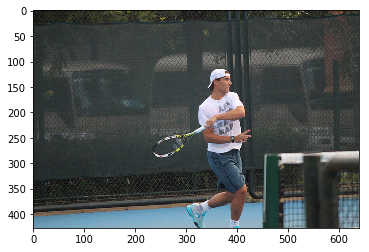

In [160]:
plt.imshow(i)

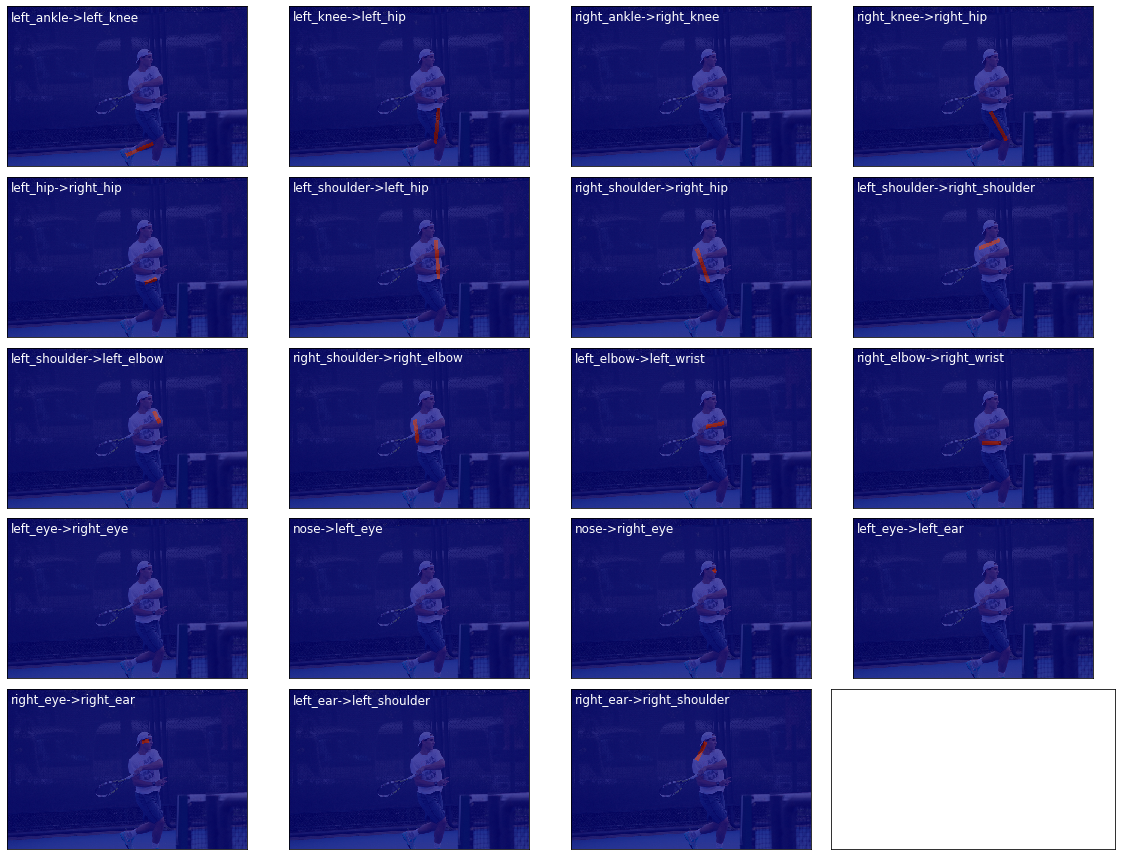

In [162]:
plot_pafs(i, paf)

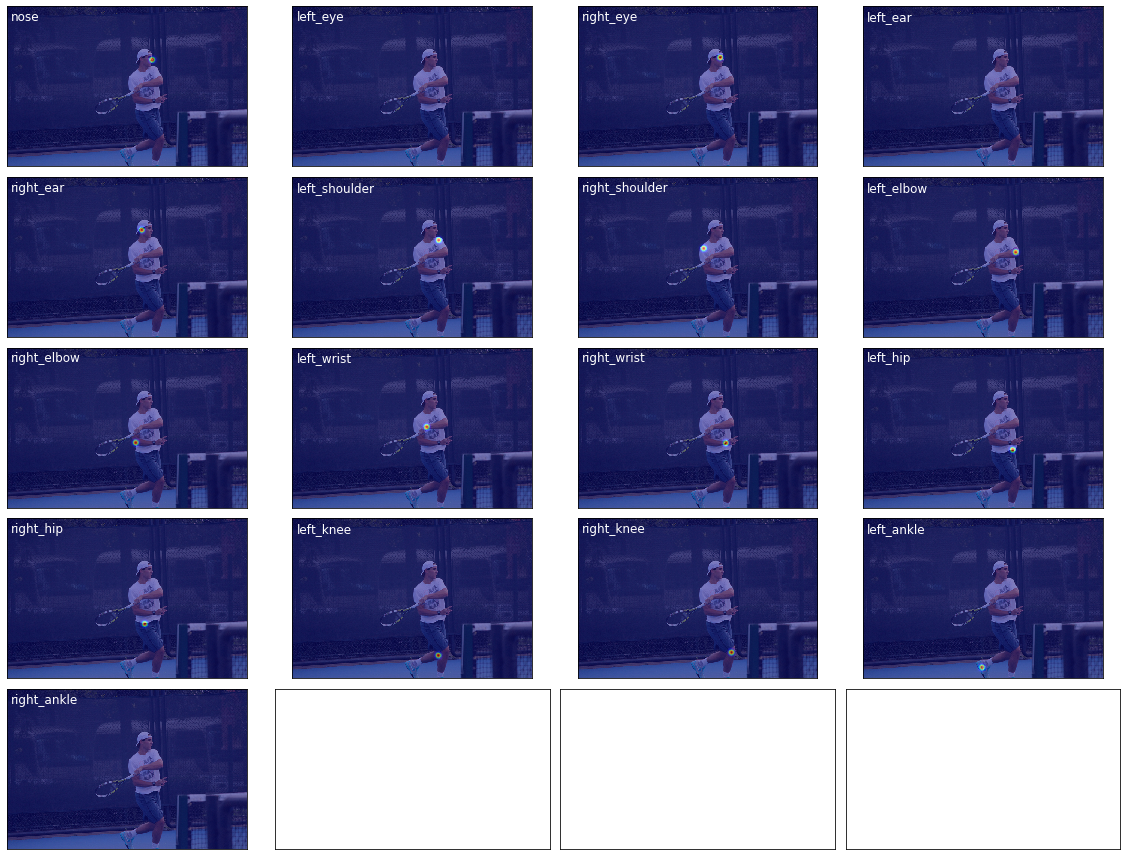

In [144]:
plot_heatmaps(i, hm)

In [38]:
from torchvision.models import vgg19

class F(nn.Module):
    def __init__(self):
        super(F, self).__init__()
        vgg = vgg19(pretrained=True).features[:23]
        for c in vgg.parameters():
            c.requires_grad = False
            
        self.vgg = vgg
        self.conv_4_3_and_4_4 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.ReLU(inplace=True)
        )

        
    def forward(self, x):
        return self.conv_4_3_and_4_4(self.vgg(x))

In [70]:
class InitialBlockType(nn.Module):
    def __init__(self, out_channels):
        super(InitialBlockType, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 512, 1, 1, 0),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, out_channels, 1, 1, 0)
        )
        
    def forward(self, x):
        return self.block(x)

class RefinementBlockType(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RefinementBlockType, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, 128, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 7, 1, 3),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 7, 1, 3),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 512, 1, 1, 0),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, out_channels, 1, 1, 0)
        )
        
    def forward(self, x):
        return self.block(x)

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        n_heatmaps = 17
        n_pafs = 38
        F_out = 128
        stage_2_in = F_out+n_heatmaps+n_pafs
        self.F = F()
        self.Stage_1_1 = InitialBlockType(n_heatmaps)
        self.Stage_1_2 = InitialBlockType(n_pafs)        
        self.Stage_2_1 = RefinementBlockType(stage_2_in, n_heatmaps)
        self.Stage_2_2 = RefinementBlockType(stage_2_in, n_pafs)
        self.Stage_3_1 = RefinementBlockType(stage_2_in, n_heatmaps)
        self.Stage_3_2 = RefinementBlockType(stage_2_in, n_pafs)
        self.Stage_4_1 = RefinementBlockType(stage_2_in, n_heatmaps)
        self.Stage_4_2 = RefinementBlockType(stage_2_in, n_pafs)
        self.Stage_5_1 = RefinementBlockType(stage_2_in, n_heatmaps)
        self.Stage_5_2 = RefinementBlockType(stage_2_in, n_pafs)
        self.Stage_6_1 = RefinementBlockType(stage_2_in, n_heatmaps)
        self.Stage_6_2 = RefinementBlockType(stage_2_in, n_pafs)

        
    def forward(self, x):
        image_features = self.F(x)                                           #128x28x28
        o_1_1 = self.Stage_1_1(image_features)                               #17x28x28
        o_1_2 = self.Stage_1_2(image_features)                               #34x28x28
        
        i_2 = torch.cat((image_features, o_1_1, o_1_2), dim=1)               #(128+17+34)x28x28
        o_2_1 = self.Stage_2_1(i_2)                                          #17x28x28
        o_2_2 = self.Stage_2_2(i_2)                                          #34x28x28
        
        i_3 = torch.cat((image_features, o_2_1, o_2_2), dim=1)               #(128+17+34)x28x28
        o_3_1 = self.Stage_3_1(i_3)                                          #17x28x28
        o_3_2 = self.Stage_3_2(i_3)                                          #34x28x28
        
        i_4 = torch.cat((image_features, o_3_1, o_3_2), dim=1)               #(128+17+34)x28x28
        o_4_1 = self.Stage_4_1(i_4)                                          #17x28x28
        o_4_2 = self.Stage_4_2(i_4)                                          #34x28x28
        
        i_5 = torch.cat((image_features, o_4_1, o_4_2), dim=1)               #(128+17+34)x28x28
        o_5_1 = self.Stage_5_1(i_5)                                          #17x28x28
        o_5_2 = self.Stage_5_2(i_5)                                          #34x28x28
        
        i_6 = torch.cat((image_features, o_5_1, o_5_2), dim=1)               #(128+17+34)x28x28
        o_6_1 = self.Stage_6_1(i_6)                                          #17x28x28
        o_6_2 = self.Stage_6_2(i_6)                                          #34x28x28
    
        return o_6_1, o_6_2

In [72]:
net = Net()

In [73]:
hm,paf = net(torch.ones(1,3,224,224))